# TO DO:
- try longer train, so lh from distributions is close to lh of the mean
- compare with fixed R
- ML research with `hrg_likelihood_T0`

In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import *
from torch import autograd
torch.manual_seed(82)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


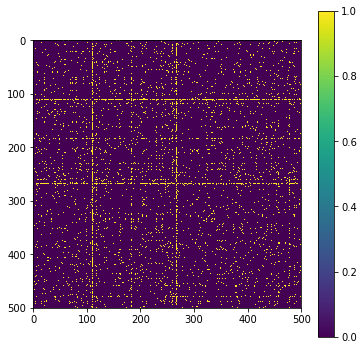

In [4]:
N = 500
R = 8.0
alpha = 0.8
T = 0

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
#G.plot()

In [5]:
A.sum().item()/N**2

0.052256

In [23]:

r_zzz = noise_r(r, R, rel_var=0.1)
phi_zzz = noise_phi(theta, 0.1)

r_loc_init = logit(r/R)
r_scale_init = (torch.ones([N])/8).log()
phi_loc_init = polar2cart(1, theta)
phi_scale_init = (torch.ones([N])*100).log()
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()
dataloader = DataLoader(EdgesDataset(A, directed=False, diagonal=False), 
                        batch_size=int(N*16), num_workers=0, shuffle=True)
vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init},
           fixed={'R':None, 
                  'T':0.1,
                  'alpha':0.75},
           priors={'R_p':torch.tensor([20., 0.4]), 
                    'T_p':torch.tensor([1., 15.]),
                    'alpha_p':torch.tensor([27., 0.03])},)

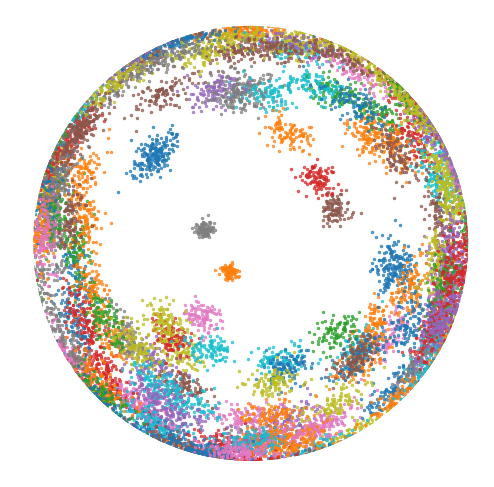

In [24]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
#print('Likelihood:', vi.likelihood())

In [25]:
vi.train(dataloader, lrs=[0.1, 0.01], debug=False, epochs=[30,50])

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 55951.17 | Epoch time 3.13
Epoch 2 | LR: 0.10 | Total loss: 50835.87 | Epoch time 3.43
Epoch 3 | LR: 0.10 | Total loss: 47850.03 | Epoch time 3.45
Epoch 4 | LR: 0.10 | Total loss: 46976.98 | Epoch time 3.03
Epoch 5 | LR: 0.10 | Total loss: 43750.01 | Epoch time 3.15
Epoch 6 | LR: 0.10 | Total loss: 42709.95 | Epoch time 3.19
Epoch 7 | LR: 0.10 | Total loss: 39966.80 | Epoch time 3.24
Epoch 8 | LR: 0.10 | Total loss: 39395.78 | Epoch time 3.37
Epoch 9 | LR: 0.10 | Total loss: 38652.86 | Epoch time 3.22
Epoch 10 | LR: 0.10 | Total loss: 37545.41 | Epoch time 3.34
Epoch 11 | LR: 0.10 | Total loss: 37085.32 | Epoch time 3.21
Epoch 12 | LR: 0.10 | Total loss: 35824.04 | Epoch time 3.27
Epoch 13 | LR: 0.10 | Total loss: 34675.75 | Epoch time 3.41
Epoch 14 | LR: 0.10 | Total loss: 34615.52 | Epoch time 3.15
Epoch 15 | LR: 0.10 | Total loss: 31993.38 | Epoch time 3.19
Epoch 16 | LR: 0.10 | Total loss: 32553.56 | Epoch time 3.18
Ep

In [26]:
vi.likelihood(debug=False)

-9855.839089559226

In [42]:
def hrg_likelihood_T0(A, r, phi_polar, R, T, alpha, debug=False):
    eps = -1e+10
    n = len(r)
    edges = torch.where(A>0, 
                            torch.ones(A.size()), 
                            torch.zeros(A.size()))
    l1e_a_ri = log1mexp(alpha*r*2)
    #print(l1e_a_ri.sum())
    l1e_a_R = log1mexp(alpha*R)
   # print(l1e_a_R)
    a_R_ri = alpha * (r-R)
    #print(a_R_ri.sum())
    r_matrix = r.expand(n,n)
    phi_matrix = phi_polar.expand(n,n)
    hd = hyperdist(r_matrix, r_matrix.t(), phi_matrix, phi_matrix.t())
    if T==0:
        threshold = torch.where(hd<R,
                                torch.zeros(hd.size()),
                                torch.ones(hd.size())*eps)
        threshold_ = torch.where(hd<R,
                                torch.ones(hd.size())*eps,
                                torch.zeros(hd.size()))
        
        #threshold = torch.clamp(((cd*2).log()<R).float(), min=1e-2)
        #print(threshold)
        lp = torch.where(edges==1,
                        threshold,
                        threshold_)
        #lp = edges*(threshold.log()) + (1-edges)*(1-threshold).log()
    else:
        l1pe = (hd-R)/(2*T)
        lp = edges*(-log1pexp(l1pe)) + (1-edges)*(log1pexp_(l1pe))
    lp = lp.triu(diagonal=1)
    #print(lp)
    if debug: print('Prob edges >>', lp.sum().item())
    if debug: print('a_R_ri  >>', (a_R_ri+l1e_a_ri).sum().item())
    if debug: print('Alpha       >>', alpha.log().item())
    if debug: print('l1e_a_R     >>', 2*l1e_a_R.item())
    out = lp.sum() + (a_R_ri+l1e_a_ri).sum() + alpha.log() \
        - torch.tensor(np.pi*2).log() - 2*l1e_a_R
    return lp

In [29]:
# Original values, T=0
hrg_likelihood_T0(A, r, theta, torch.tensor(R), torch.tensor(0.), torch.tensor(alpha), debug=True)

Prob edges >> 0.0
a_R_ri  >> -439.50470501739073
Alpha       >> -0.2231435328722
l1e_a_R     >> -0.0033258781768381596


-441.5623997072271

In [30]:
# Original values except T=0.1
hrg_likelihood_T0(A, r, theta, torch.tensor(R), torch.tensor(0.1), torch.tensor(alpha), debug=True)

Prob edges >> -1128.5018663019835
a_R_ri  >> -439.50470501739073
Alpha       >> -0.2231435328722
l1e_a_R     >> -0.0033258781768381596


-1570.0642660092105

In [31]:
r_, phi_, R_, T_, alpha_ = vi.qmean()
R_, T_, alpha_

(tensor(8.3670, dtype=torch.float64),
 tensor(0.1000, dtype=torch.float64),
 tensor(0.7500, dtype=torch.float64))

In [44]:
# Estimated values
lp = hrg_likelihood_T0(A, r_, c2d(phi_), R_, T_ , alpha_, debug=True)

Prob edges >> -4661.64840720798
a_R_ri  >> -433.47291400329345
Alpha       >> -0.2876820724517809
l1e_a_R     >> -0.003768247601152892


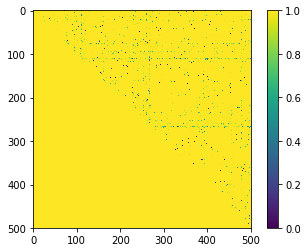

In [53]:
np.set_printoptions(precision=2)
plt.imshow(lp.exp())
plt.colorbar()
plt.show()

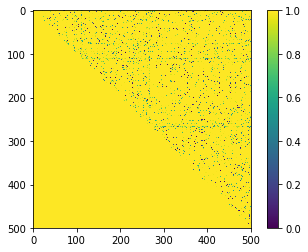

In [54]:
A_lh = vi.get_A_lh(dataloader)
plt.imshow(A_lh.exp())
plt.colorbar()
plt.show()

In [55]:
A_lh.sum()

tensor(-9886.9246, dtype=torch.float64)

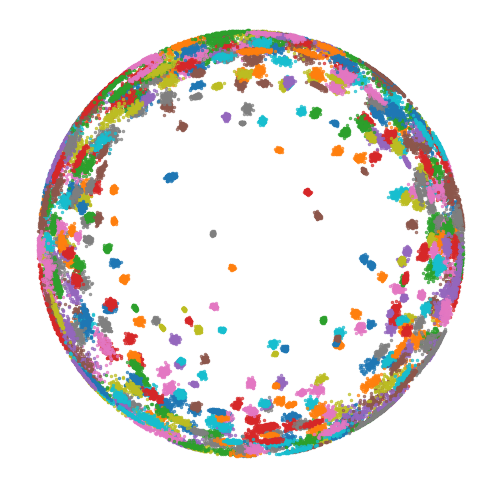

Likelihood: -10033.585979758891


In [35]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi.likelihood())

In [ ]:
hrg_likelihood_T0(A, r, theta, torch.tensor(R), torch.tensor(0.001), torch.tensor(alpha), debug=True)

In [ ]:
hrg_likelihood_T0(A, r, theta, torch.tensor(R), torch.tensor(0.0001), torch.tensor(alpha), debug=False)

In [ ]:
A

In [ ]:
torch.ones([4,4]).triu(diagonal=1)

In [ ]:
idx1 = torch.tensor([1,2,3,4,5,6])
idx2 = torch.tensor([2,2,4,1,5,3])
idx1, idx2 = idx1[idx1<idx2], idx2[idx1<idx2]
idx1, idx2